In [8]:
import mygrad as mg
from mygrad.nnet.losses.margin_ranking_loss import margin_ranking_loss
import mynn
import numpy as np

from mygrad.nnet.initializers import glorot_normal
from mynn.layers.dense import dense
from mynn.optimizers.sgd import SGD
from mynn.optimizers.adam import Adam

from pathlib import Path
import json
import io
import requests
from PIL import Image
from gensim.models import KeyedVectors
import pickle
from collections import defaultdict
import random
import time

import matplotlib.pyplot as plt
%matplotlib notebook

/Users/ssharma/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [10]:
# load COCO metadata
filename = "data/captions_train2014.json"
with Path(filename).open() as f:
    coco_data = json.load(f)
    
# Loading GloVe-200
filename = "data/glove.6B.200d.txt.w2v"
t0 = time.time()
glove = KeyedVectors.load_word2vec_format(filename, binary=False)
t1 = time.time()
print("elapsed %ss" % (t1 - t0))

# Loading ResNet Descriptors
with Path('data/resnet18_features.pkl').open('rb') as f:
    resnet18_features = pickle.load(f)
    
def download_image(img_url: str) -> Image:
    """Fetches an image from the web.

    Parameters
    ----------
    img_url : string
        The url of the image to fetch.

    Returns
    -------
    PIL.Image
        The image."""

    response = requests.get(img_url)
    return Image.open(io.BytesIO(response.content))

elapsed 61.01415705680847s


In [89]:
import re, string
import numpy as np
import mygrad as mg

from collections import Counter

punc_regex = re.compile('[{}]'.format(re.escape(string.punctuation)))

def tokenize(text):
    return punc_regex.sub('', text).lower().split()

def to_vocab(list_of_counters, k=None, stop_words=tuple()):
    """ 
    [word, word, ...] -> sorted list of top-k unique words
    Excludes words included in `stop_words`
    
    Parameters
    ----------
    list_of_counters : Iterable[Iterable[str]]
    
    k : Optional[int]
        If specified, only the top-k words are returned
    
    stop_words : Collection[str]
        A collection of words to be ignored when populating the vocabulary
    """
    # <COGINST>
    vocab = Counter()
    for counter in list_of_counters:
        vocab.update(counter)
        
    for word in set(stop_words):
        vocab.pop(word, None)  # if word not in bag, return None
    return sorted(i for i,j in vocab.most_common(k))
    # </COGINST>

def phrase_idf(phrase_vocab, list_of_counters):
    N = len(list_of_counters)
    #print(N)
    #print(phrase_vocab)
    
    # if term i is not in glove, we set nt[i] = N that way its corresponding idf value is 0
    start = time.time()
    nt = [sum(1 if term in counter else 0 for counter in list_of_counters) for term in phrase_vocab]
    print('creating nt: {}'.format(time.time() - start))
    nt = np.array(nt, dtype=float)
    
    nt[nt == 0] = N
    
    #print(nt)
    return np.log10(N / nt)

In [90]:
class Database:
    def __init__(self):
        self.ID_to_descriptor = resnet18_features
        self.ID_to_URL = dict()
        self.ID_to_captions = defaultdict(list) # key:value | ID --> list of captions corresonding to ID
        # NOTE: USE "glove" TO CONVERT WORD --> WORD EMBEDDING
        
        # Getting ID --> URL:
        for i in range(len(coco_data["images"])):
            ID = coco_data["images"][i]['id']
            URL = coco_data["images"][i]['coco_url']
            self.ID_to_URL[ID] = URL
        
        # Getting ID --> Captions
        for i in range(len(coco_data["annotations"])):
            ID = coco_data["annotations"][i]['image_id']
            caption = coco_data["annotations"][i]['caption']
            self.ID_to_captions[ID].append(caption)
        
        # Initialize the dataset
        self.make_dataset()
        
        # Shuffle datasets
        self.shuffle_dataset()
        
        # Making List of caption_counters
        self.list_of_caption_counters = []
        for ID in self.ID_to_captions:
            captions = self.ID_to_captions[ID]
            for caption in captions:
                self.list_of_caption_counters.append(Counter(tokenize(caption)))
    
    # This funciton creates the dataset (only call this once during initialization process)
    def make_dataset(self):
        list_of_IDs = list(self.ID_to_descriptor.keys())
        N = len(list_of_IDs)
        self.dataset = np.zeros((N, 3), dtype=np.int64) # Shape: N, 3
        
        for i in range(N):
            ID = list_of_IDs[i]
            confuser_ID =list_of_IDs[random.randint(0, N-1)]
            while ID == confuser_ID: # Just to make sure that the randomly picked confuser ID isn't the same as the img ID; 1/N chance of happening
                confuser_ID = list_of_IDs[random.randint(0, N-1)]
            caption_index = random.randint(0, len(self.ID_to_captions[ID])-1)
            
            self.dataset[i][0] = caption_index
            self.dataset[i][1] = ID
            self.dataset[i][2] = confuser_ID
    
    '''
    This function randomly shuffles the dataset across its rows (each tuplet)
    and makes the cuts for the training & validation sets;
    call this when you want to shuffle the sets after each epoch.
    '''
    def shuffle_dataset(self):
        np.random.shuffle(self.dataset)
        cut = int(self.dataset.shape[0] * (4/5))
        self.training_set = self.dataset[0:cut]
        self.validation_set = self.dataset[cut:]
    
    # This function parses the query and returns one word embedding that represents the query
    def parse_query(self, phrase):
        phrase_vocab = to_vocab([Counter(tokenize(phrase))])

        glove_embeddings = [(glove[term] if term in glove else np.zeros(200)) for term in phrase_vocab]
        start = time.time()
        idf = phrase_idf(phrase_vocab, self.list_of_caption_counters)
        print('phrase_idf: {}'.format(time.time() - start))

        start2 = time.time()
        w_phrase = sum( glove_embeddings[i] * idf[i] for i in range(len(idf)) )
        print('w_phrase: {}'.format(time.time() - start2))

        return w_phrase / np.sqrt((w_phrase ** 2).sum(keepdims=True)) # normalized
    

In [91]:
def accuracy(true_caption_img_similarity, conf_img_similarity):
    diff = true_caption_img_similarity - conf_img_similarity
    acc = np.mean(diff > 0)
    return acc
    

In [92]:
class Encoder:
    def __init__(self):
        """ This initializes all of the layers in our model, and sets them
        as attributes of the model.
        
       
        # Initialize the encoder and decorder dense layers using the `glorot_normal` initialization
        # schemes.
        # What should the input and output dimensions of each layer be? """
        
        self.encoder = dense(512, 200, weight_initializer = glorot_normal, bias = False)
        

    def __call__(self, descriptor):
       
        '''Passes data as input to our model, performing a "forward-pass".
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(M, D_full)
            A batch of data consisting of M pieces of data,
            each with a dimentionality of D_full.
            
        Returns
        -------
        mygrad.Tensor, shape=(M, D_full)
            The model's prediction for each of the M pieces of data.
        '''
        # keep in mind that this is a linear model - there is no "activation function"
        # involved here
        normalized_descriptor = descriptor / np.sqrt((descriptor ** 2).sum(keepdims=True))
        return self.encoder(normalized_descriptor)
        
        
        
        
    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model """
        return self.encoder.parameters
        
        
        

<IPython.core.display.Javascript object>


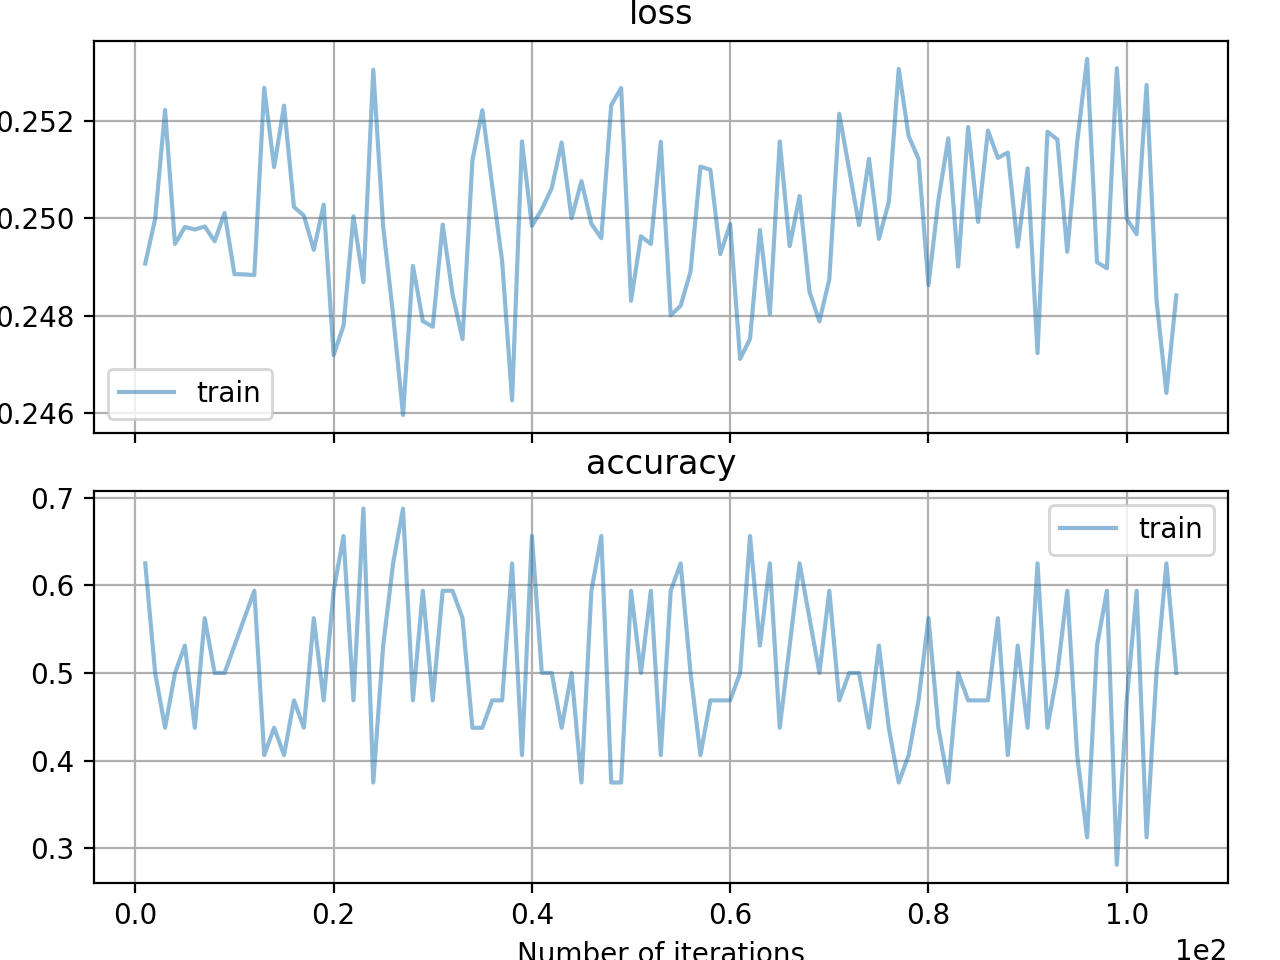

In [93]:
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

In [94]:
db = Database()
batch_size = 32
learning_rate = 1e-3
momentum = 0.9
margin = 0.25
num_epochs = 1

In [95]:
model = Encoder()
optim = SGD(model.parameters, learning_rate = learning_rate, momentum = momentum)

In [ ]:
for epoch_cnt in range(num_epochs):
   
    db.shuffle_dataset()
    idxs = np.arange(0, len(db.training_set))
    np.random.shuffle(idxs)
    
    for batch_cnt in range(0, len(db.training_set) // batch_size):
        
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = db.training_set[batch_indices]  # list of tuples with 3 indexes
        
        true_caption_id = batch[:, 0] # get only captions from each tuple
        true_image_id  = batch[:, 1] # get true image
        confuser_image_id  = batch[:, 2] # get confuser
    
        start = time.time()
        captions = []
        for i in range(len(true_caption_id)):
            captions.append(db.ID_to_captions[true_image_id[i]][true_caption_id[i]])
        print('First for loop: {}'.format(time.time() - start))
        
        start2 = time.time()
        caption_embedding = []
        for caption in captions:
            caption_embedding.append(db.parse_query(caption))
        caption_embedding = np.array(caption_embedding)
        print('Second for loop: {} s'.format(time.time() - start2))
        
        true_img_desc = []
        conf_img_desc = []
        
        for img_id, conf_id in zip(true_image_id, confuser_image_id): 
            
            true_img_desc.append(db.ID_to_descriptor[img_id])
            conf_img_desc.append(db.ID_to_descriptor[conf_id])
            
         
        true_img_desc = np.vstack(true_img_desc)
        conf_img_desc = np.vstack(conf_img_desc)
        
        
        w_true = model(true_img_desc)
        w_confuser = model(conf_img_desc)
        
        
        true_caption_img_similarity = mg.einsum('ni, ni -> n', caption_embedding, w_true)
        conf_caption_img_similarity = mg.einsum('ni, ni -> n', caption_embedding, w_confuser)
        
        
        train_acc = accuracy(true_caption_img_similarity, conf_caption_img_similarity)
        loss = margin_ranking_loss(true_caption_img_similarity,conf_caption_img_similarity, y=1.0, margin=margin)

       
        # back-propagate through your computational graph through your loss
      
        loss.backward()
        

        # execute gradient-descent by calling step() of optim
        optim.step()
        
        plotter.set_train_batch({"loss" : loss.item(), "accuracy": train_acc},
                                 batch_size=batch_size)
    plotter.set_train_epoch()
    
    
    test_idxs = np.arange(0, len(db.validation_set))
    for batch_cnt in range(0, len(db.validation_set) // batch_size):
        test_indices = test_idxs[batch_cnt*batch_size:(batch_cnt+1)*batch_size]
        test_batch = db.validation_set[test_indices]
        true_caption_id = test_batch[:, 0]
        true_image_id  = test_batch[:, 1] # get true image
        confuser_image_id  = test_batch[:, 2] # get confuser
        with mg.no_autodiff:
            w_test = model(test_batch)
            captions = []
            for i in range(len(true_caption_id)):
                captions.append(db.ID_to_captions[true_image_id[i]][true_caption_id[i]])
        caption_embedding = []
        for caption in captions:
            caption_embedding.append(db.parse_query(caption))
        caption_embedding = np.array(caption_embedding)
        true_img_desc = []
        conf_img_desc = []
        for img_id, conf_id in zip(true_image_id, confuser_image_id): 

            true_img_desc.append(db.ID_to_descriptor[img_id])
            conf_img_desc.append(db.ID_to_descriptor[conf_id])


        true_img_desc = np.vstack(true_img_desc)
        conf_img_desc = np.vstack(conf_img_desc)
    
        w_true = model(true_img_desc)
        w_confuser = model(conf_img_desc)
        true_caption_img_similarity = mg.einsum('ni, ni -> n', caption_embedding, w_true)
        conf_caption_img_similarity = mg.einsum('ni, ni -> n', caption_embedding, w_confuser)
        test_acc = accuracy(true_caption_img_similarity, conf_caption_img_similarity)
        plotter.set_test_batch({"accuracy": test_acc}, batch_size=batch_size)
    plotter.set_test_epoch()
    

First for loop: 9.298324584960938e-05
creating nt: 0.7208800315856934
phrase_idf: 0.7210419178009033
w_phrase: 4.506111145019531e-05
creating nt: 0.6888630390167236
phrase_idf: 0.6890678405761719
w_phrase: 0.0019567012786865234
creating nt: 0.474703311920166
phrase_idf: 0.47490501403808594
w_phrase: 3.910064697265625e-05
creating nt: 0.5503649711608887
phrase_idf: 0.5507450103759766
w_phrase: 0.0003447532653808594
creating nt: 0.6174569129943848
phrase_idf: 0.6176869869232178
w_phrase: 0.001909017562866211
creating nt: 0.6452231407165527
phrase_idf: 0.6453843116760254
w_phrase: 5.507469177246094e-05
creating nt: 0.9223060607910156
phrase_idf: 0.922471284866333
w_phrase: 6.794929504394531e-05
creating nt: 0.43245697021484375
phrase_idf: 0.4326162338256836
w_phrase: 4.100799560546875e-05
creating nt: 0.5461552143096924
phrase_idf: 0.5464539527893066
w_phrase: 0.00011801719665527344
creating nt: 0.5199489593505859
phrase_idf: 0.5202231407165527
w_phrase: 3.790855407714844e-05
creating nt:

creating nt: 0.48508524894714355
phrase_idf: 0.485260009765625
w_phrase: 4.291534423828125e-05
creating nt: 0.41341090202331543
phrase_idf: 0.41361308097839355
w_phrase: 3.886222839355469e-05
creating nt: 0.4596211910247803
phrase_idf: 0.4598660469055176
w_phrase: 6.985664367675781e-05
creating nt: 0.5469980239868164
phrase_idf: 0.5471620559692383
w_phrase: 0.00010609626770019531
creating nt: 0.7206258773803711
phrase_idf: 0.7208812236785889
w_phrase: 5.316734313964844e-05
creating nt: 0.549797773361206
phrase_idf: 0.5499410629272461
w_phrase: 8.0108642578125e-05
creating nt: 1.2115609645843506
phrase_idf: 1.2117509841918945
w_phrase: 6.890296936035156e-05
creating nt: 0.5725469589233398
phrase_idf: 0.572739839553833
w_phrase: 5.602836608886719e-05
creating nt: 0.5356547832489014
phrase_idf: 0.5358560085296631
w_phrase: 4.1961669921875e-05
creating nt: 0.532757043838501
phrase_idf: 0.5329878330230713
w_phrase: 0.001987934112548828
creating nt: 0.4632558822631836
phrase_idf: 0.463402032

creating nt: 1.083956003189087
phrase_idf: 1.0843100547790527
w_phrase: 0.00012302398681640625
creating nt: 0.6398887634277344
phrase_idf: 0.6400477886199951
w_phrase: 4.410743713378906e-05
creating nt: 0.6101202964782715
phrase_idf: 0.6106338500976562
w_phrase: 0.0019631385803222656
creating nt: 0.5933849811553955
phrase_idf: 0.5936613082885742
w_phrase: 0.00016427040100097656
creating nt: 0.41686129570007324
phrase_idf: 0.41704487800598145
w_phrase: 3.719329833984375e-05
creating nt: 0.6255369186401367
phrase_idf: 0.6256928443908691
w_phrase: 5.1975250244140625e-05
creating nt: 0.522852897644043
phrase_idf: 0.5230488777160645
w_phrase: 0.000102996826171875
creating nt: 0.5281879901885986
phrase_idf: 0.528388261795044
w_phrase: 6.866455078125e-05
creating nt: 0.5355238914489746
phrase_idf: 0.53584885597229
w_phrase: 0.00011587142944335938
creating nt: 0.7726390361785889
phrase_idf: 0.7728142738342285
w_phrase: 6.175041198730469e-05
creating nt: 0.42427897453308105
phrase_idf: 0.424474

creating nt: 1.0365111827850342
phrase_idf: 1.036707878112793
w_phrase: 6.556510925292969e-05
Second for loop: 24.08024573326111 s
First for loop: 0.0009219646453857422
creating nt: 0.5580410957336426
phrase_idf: 0.5581932067871094
w_phrase: 4.00543212890625e-05
creating nt: 0.540104866027832
phrase_idf: 0.540273904800415
w_phrase: 4.100799560546875e-05
creating nt: 1.2193710803985596
phrase_idf: 1.2203471660614014
w_phrase: 0.000102996826171875
creating nt: 0.8175449371337891
phrase_idf: 0.8177909851074219
w_phrase: 8.177757263183594e-05
creating nt: 0.6452829837799072
phrase_idf: 0.6454360485076904
w_phrase: 5.0067901611328125e-05
creating nt: 0.6044449806213379
phrase_idf: 0.6047821044921875
w_phrase: 5.2928924560546875e-05
creating nt: 1.0211069583892822
phrase_idf: 1.021285057067871
w_phrase: 6.103515625e-05
creating nt: 0.8197331428527832
phrase_idf: 0.8198881149291992
w_phrase: 6.604194641113281e-05
creating nt: 0.559607982635498
phrase_idf: 0.5598289966583252
w_phrase: 0.001977

creating nt: 0.6290171146392822
phrase_idf: 0.6291677951812744
w_phrase: 7.510185241699219e-05
creating nt: 0.5914440155029297
phrase_idf: 0.5916070938110352
w_phrase: 8.392333984375e-05
creating nt: 0.4171741008758545
phrase_idf: 0.4173319339752197
w_phrase: 5.030632019042969e-05
creating nt: 0.6680240631103516
phrase_idf: 0.6682260036468506
w_phrase: 0.00012874603271484375
creating nt: 0.6199371814727783
phrase_idf: 0.6201307773590088
w_phrase: 5.3882598876953125e-05
creating nt: 0.4535350799560547
phrase_idf: 0.4537510871887207
w_phrase: 8.988380432128906e-05
creating nt: 0.5580630302429199
phrase_idf: 0.5582931041717529
w_phrase: 5.91278076171875e-05
creating nt: 0.6358547210693359
phrase_idf: 0.6360552310943604
w_phrase: 6.604194641113281e-05
creating nt: 0.5496349334716797
phrase_idf: 0.5498702526092529
w_phrase: 9.918212890625e-05
creating nt: 0.5335841178894043
phrase_idf: 0.5338339805603027
w_phrase: 4.887580871582031e-05
creating nt: 0.4658088684082031
phrase_idf: 0.466017723

creating nt: 0.6150989532470703
phrase_idf: 0.6153149604797363
w_phrase: 5.2928924560546875e-05
creating nt: 0.661855936050415
phrase_idf: 0.6620237827301025
w_phrase: 8.320808410644531e-05
creating nt: 0.6716630458831787
phrase_idf: 0.671860933303833
w_phrase: 9.703636169433594e-05
creating nt: 0.5271987915039062
phrase_idf: 0.5273418426513672
w_phrase: 6.198883056640625e-05
creating nt: 0.7414002418518066
phrase_idf: 0.7415628433227539
w_phrase: 0.0019860267639160156
creating nt: 0.41104626655578613
phrase_idf: 0.41130805015563965
w_phrase: 5.984306335449219e-05
creating nt: 0.47029709815979004
phrase_idf: 0.4705185890197754
w_phrase: 7.390975952148438e-05
creating nt: 0.6289160251617432
phrase_idf: 0.6294839382171631
w_phrase: 0.0003452301025390625
creating nt: 0.5248968601226807
phrase_idf: 0.5250601768493652
w_phrase: 6.29425048828125e-05
creating nt: 0.9816510677337646
phrase_idf: 0.9818141460418701
w_phrase: 0.00016021728515625
creating nt: 0.49637603759765625
phrase_idf: 0.4965

creating nt: 0.5676639080047607
phrase_idf: 0.5679171085357666
w_phrase: 5.0067901611328125e-05
creating nt: 0.6452362537384033
phrase_idf: 0.6459028720855713
w_phrase: 0.00012111663818359375
creating nt: 0.5984799861907959
phrase_idf: 0.5986490249633789
w_phrase: 6.175041198730469e-05
Second for loop: 20.001736164093018 s
First for loop: 0.0007159709930419922
creating nt: 0.5013422966003418
phrase_idf: 0.5017926692962646
w_phrase: 0.00010180473327636719
creating nt: 0.602816104888916
phrase_idf: 0.6033210754394531
w_phrase: 0.0009889602661132812
creating nt: 0.700955867767334
phrase_idf: 0.7015128135681152
w_phrase: 0.0021419525146484375
creating nt: 0.6902239322662354
phrase_idf: 0.6904370784759521
w_phrase: 5.817413330078125e-05
creating nt: 0.7074298858642578
phrase_idf: 0.7077839374542236
w_phrase: 4.601478576660156e-05
creating nt: 0.5584676265716553
phrase_idf: 0.5588099956512451
w_phrase: 5.6743621826171875e-05
creating nt: 0.5458409786224365
phrase_idf: 0.5460431575775146
w_ph

creating nt: 0.725200891494751
phrase_idf: 0.7253620624542236
w_phrase: 5.2928924560546875e-05
creating nt: 0.6644399166107178
phrase_idf: 0.6646358966827393
w_phrase: 0.0001010894775390625
creating nt: 0.5999929904937744
phrase_idf: 0.6001861095428467
w_phrase: 6.29425048828125e-05
creating nt: 0.5573058128356934
phrase_idf: 0.5574648380279541
w_phrase: 4.410743713378906e-05
creating nt: 0.42688918113708496
phrase_idf: 0.4270501136779785
w_phrase: 6.127357482910156e-05
creating nt: 0.9788563251495361
phrase_idf: 0.9790208339691162
w_phrase: 7.390975952148438e-05
creating nt: 0.41185712814331055
phrase_idf: 0.412006139755249
w_phrase: 3.814697265625e-05
creating nt: 0.7608652114868164
phrase_idf: 0.761052131652832
w_phrase: 5.91278076171875e-05
creating nt: 0.46703577041625977
phrase_idf: 0.4673318862915039
w_phrase: 7.891654968261719e-05
creating nt: 0.4418680667877197
phrase_idf: 0.4420351982116699
w_phrase: 4.100799560546875e-05
creating nt: 0.4691951274871826
phrase_idf: 0.46934700

creating nt: 0.5339610576629639
phrase_idf: 0.5343019962310791
w_phrase: 6.604194641113281e-05
creating nt: 0.5511050224304199
phrase_idf: 0.5513248443603516
w_phrase: 7.486343383789062e-05
creating nt: 0.9134840965270996
phrase_idf: 0.913722038269043
w_phrase: 0.0019888877868652344
creating nt: 0.5986402034759521
phrase_idf: 0.5988268852233887
w_phrase: 4.506111145019531e-05
creating nt: 0.6233904361724854
phrase_idf: 0.6238079071044922
w_phrase: 4.601478576660156e-05
creating nt: 0.5823988914489746
phrase_idf: 0.5825710296630859
w_phrase: 4.410743713378906e-05
creating nt: 0.6132102012634277
phrase_idf: 0.6134059429168701
w_phrase: 4.7206878662109375e-05
creating nt: 0.5993647575378418
phrase_idf: 0.5995199680328369
w_phrase: 4.506111145019531e-05
creating nt: 0.49414896965026855
phrase_idf: 0.49429988861083984
w_phrase: 4.100799560546875e-05
creating nt: 0.5662698745727539
phrase_idf: 0.56646728515625
w_phrase: 6.031990051269531e-05
creating nt: 0.3573932647705078
phrase_idf: 0.3575

creating nt: 0.5425999164581299
phrase_idf: 0.5428259372711182
w_phrase: 5.698204040527344e-05
creating nt: 0.45140719413757324
phrase_idf: 0.45163989067077637
w_phrase: 0.0001709461212158203
creating nt: 0.527446985244751
phrase_idf: 0.5280179977416992
w_phrase: 6.4849853515625e-05
creating nt: 0.595689058303833
phrase_idf: 0.5958361625671387
w_phrase: 4.601478576660156e-05
creating nt: 0.5584919452667236
phrase_idf: 0.5587267875671387
w_phrase: 4.410743713378906e-05
Second for loop: 19.005270957946777 s
First for loop: 0.0009038448333740234
creating nt: 0.4796159267425537
phrase_idf: 0.47997307777404785
w_phrase: 0.003055095672607422
creating nt: 0.6027891635894775
phrase_idf: 0.602973222732544
w_phrase: 5.7697296142578125e-05
creating nt: 0.816591739654541
phrase_idf: 0.8167860507965088
w_phrase: 0.0021016597747802734
creating nt: 0.48253893852233887
phrase_idf: 0.4827079772949219
w_phrase: 7.486343383789062e-05
creating nt: 0.7674770355224609
phrase_idf: 0.7679486274719238
w_phrase

creating nt: 0.4191420078277588
phrase_idf: 0.4193398952484131
w_phrase: 3.981590270996094e-05
creating nt: 0.49194979667663574
phrase_idf: 0.4921438694000244
w_phrase: 5.4836273193359375e-05
creating nt: 0.5415871143341064
phrase_idf: 0.5417459011077881
w_phrase: 5.5789947509765625e-05
creating nt: 0.4901289939880371
phrase_idf: 0.49032020568847656
w_phrase: 4.1961669921875e-05
creating nt: 0.4082028865814209
phrase_idf: 0.40840911865234375
w_phrase: 4.410743713378906e-05
creating nt: 0.5486006736755371
phrase_idf: 0.5487749576568604
w_phrase: 5.412101745605469e-05
creating nt: 0.8000800609588623
phrase_idf: 0.8003182411193848
w_phrase: 6.508827209472656e-05
creating nt: 0.5043261051177979
phrase_idf: 0.504492998123169
w_phrase: 4.100799560546875e-05
creating nt: 0.4271419048309326
phrase_idf: 0.4273340702056885
w_phrase: 3.886222839355469e-05
creating nt: 0.6208634376525879
phrase_idf: 0.6210567951202393
w_phrase: 4.410743713378906e-05
creating nt: 0.4680299758911133
phrase_idf: 0.46

creating nt: 0.5370831489562988
phrase_idf: 0.5372798442840576
w_phrase: 6.914138793945312e-05
creating nt: 0.5073950290679932
phrase_idf: 0.5075669288635254
w_phrase: 4.00543212890625e-05
creating nt: 0.4552302360534668
phrase_idf: 0.455521821975708
w_phrase: 0.0020198822021484375
creating nt: 0.4216959476470947
phrase_idf: 0.4221839904785156
w_phrase: 9.107589721679688e-05
creating nt: 0.5669519901275635
phrase_idf: 0.5671381950378418
w_phrase: 5.817413330078125e-05
creating nt: 0.5099027156829834
phrase_idf: 0.5103991031646729
w_phrase: 4.506111145019531e-05
creating nt: 0.5467529296875
phrase_idf: 0.5469341278076172
w_phrase: 4.887580871582031e-05
creating nt: 0.5510311126708984
phrase_idf: 0.5512242317199707
w_phrase: 4.410743713378906e-05
creating nt: 0.6008181571960449
phrase_idf: 0.6010029315948486
w_phrase: 4.792213439941406e-05
creating nt: 0.46871423721313477
phrase_idf: 0.46892786026000977
w_phrase: 0.0020558834075927734
creating nt: 0.5254120826721191
phrase_idf: 0.5256829

creating nt: 0.4732208251953125
phrase_idf: 0.4733719825744629
w_phrase: 3.886222839355469e-05
creating nt: 0.6914160251617432
phrase_idf: 0.6916248798370361
w_phrase: 7.605552673339844e-05
creating nt: 0.5946822166442871
phrase_idf: 0.5951530933380127
w_phrase: 0.00012969970703125
creating nt: 0.7049829959869385
phrase_idf: 0.705129861831665
w_phrase: 5.817413330078125e-05
creating nt: 0.459075927734375
phrase_idf: 0.4592409133911133
w_phrase: 5.1975250244140625e-05
creating nt: 0.6271770000457764
phrase_idf: 0.6274518966674805
w_phrase: 7.081031799316406e-05
creating nt: 0.6538760662078857
phrase_idf: 0.6541008949279785
w_phrase: 4.601478576660156e-05
creating nt: 0.5785539150238037
phrase_idf: 0.5787630081176758
w_phrase: 0.0019459724426269531
Second for loop: 19.953176259994507 s
First for loop: 0.000804901123046875
creating nt: 0.5373749732971191
phrase_idf: 0.5380520820617676
w_phrase: 0.00011801719665527344
creating nt: 0.5113489627838135
phrase_idf: 0.511563777923584
w_phrase: 

creating nt: 0.5782599449157715
phrase_idf: 0.5785698890686035
w_phrase: 5.507469177246094e-05
creating nt: 0.6955389976501465
phrase_idf: 0.6958179473876953
w_phrase: 6.29425048828125e-05
creating nt: 0.5830299854278564
phrase_idf: 0.5831937789916992
w_phrase: 4.8160552978515625e-05
creating nt: 0.5013670921325684
phrase_idf: 0.5015549659729004
w_phrase: 6.794929504394531e-05
creating nt: 0.5617249011993408
phrase_idf: 0.5619149208068848
w_phrase: 5.507469177246094e-05
creating nt: 0.7746579647064209
phrase_idf: 0.7748191356658936
w_phrase: 6.198883056640625e-05
creating nt: 0.6248857975006104
phrase_idf: 0.6251180171966553
w_phrase: 9.274482727050781e-05
creating nt: 0.5070846080780029
phrase_idf: 0.5072789192199707
w_phrase: 0.00010395050048828125
creating nt: 0.47376012802124023
phrase_idf: 0.47457289695739746
w_phrase: 5.888938903808594e-05
creating nt: 0.47197866439819336
phrase_idf: 0.47217893600463867
w_phrase: 5.7220458984375e-05
creating nt: 0.6061859130859375
phrase_idf: 0.6

creating nt: 0.5319643020629883
phrase_idf: 0.5321331024169922
w_phrase: 4.1961669921875e-05
creating nt: 0.621182918548584
phrase_idf: 0.6213808059692383
w_phrase: 5.6743621826171875e-05
creating nt: 0.4852261543273926
phrase_idf: 0.48542094230651855
w_phrase: 0.0001308917999267578
creating nt: 0.6382949352264404
phrase_idf: 0.638498067855835
w_phrase: 4.8160552978515625e-05
creating nt: 0.527611255645752
phrase_idf: 0.527822732925415
w_phrase: 5.0067901611328125e-05
creating nt: 0.6050419807434082
phrase_idf: 0.605283260345459
w_phrase: 0.00018405914306640625
creating nt: 0.5173580646514893
phrase_idf: 0.517827033996582
w_phrase: 4.00543212890625e-05
creating nt: 0.8993840217590332
phrase_idf: 0.8995850086212158
w_phrase: 7.414817810058594e-05
creating nt: 0.7997078895568848
phrase_idf: 0.7998619079589844
w_phrase: 7.796287536621094e-05
creating nt: 0.6583139896392822
phrase_idf: 0.6586508750915527
w_phrase: 6.985664367675781e-05
creating nt: 0.5767910480499268
phrase_idf: 0.57695221

creating nt: 0.6452360153198242
phrase_idf: 0.6454329490661621
w_phrase: 0.00011587142944335938
creating nt: 0.4492039680480957
phrase_idf: 0.4494180679321289
w_phrase: 4.100799560546875e-05
creating nt: 0.8794441223144531
phrase_idf: 0.879857063293457
w_phrase: 7.987022399902344e-05
creating nt: 0.8240969181060791
phrase_idf: 0.8243551254272461
w_phrase: 0.0020210742950439453
creating nt: 0.4392390251159668
phrase_idf: 0.439406156539917
w_phrase: 4.100799560546875e-05
creating nt: 0.5730061531066895
phrase_idf: 0.5731701850891113
w_phrase: 0.0020160675048828125
creating nt: 0.5913598537445068
phrase_idf: 0.5915558338165283
w_phrase: 4.410743713378906e-05
creating nt: 0.8670847415924072
phrase_idf: 0.867224931716919
w_phrase: 9.989738464355469e-05
creating nt: 0.4523918628692627
phrase_idf: 0.45270395278930664
w_phrase: 6.29425048828125e-05
creating nt: 0.5205090045928955
phrase_idf: 0.5206871032714844
w_phrase: 9.322166442871094e-05
Second for loop: 19.74414896965027 s
First for loop:

creating nt: 0.5804181098937988
phrase_idf: 0.5805621147155762
w_phrase: 4.506111145019531e-05
creating nt: 0.612407922744751
phrase_idf: 0.6126217842102051
w_phrase: 4.410743713378906e-05
creating nt: 0.5267789363861084
phrase_idf: 0.526951789855957
w_phrase: 0.0002028942108154297
creating nt: 0.6617321968078613
phrase_idf: 0.6619241237640381
w_phrase: 0.001940011978149414
creating nt: 0.45529699325561523
phrase_idf: 0.4554471969604492
w_phrase: 3.886222839355469e-05
creating nt: 0.4425840377807617
phrase_idf: 0.4427928924560547
w_phrase: 7.581710815429688e-05
creating nt: 0.5185198783874512
phrase_idf: 0.5187461376190186
w_phrase: 9.703636169433594e-05
creating nt: 0.6281259059906006
phrase_idf: 0.6282751560211182
w_phrase: 5.507469177246094e-05
creating nt: 0.5787649154663086
phrase_idf: 0.578930139541626
w_phrase: 4.291534423828125e-05
creating nt: 0.5721077919006348
phrase_idf: 0.5723137855529785
w_phrase: 0.00010395050048828125
creating nt: 0.7056288719177246
phrase_idf: 0.705819

creating nt: 0.7664330005645752
phrase_idf: 0.7666475772857666
w_phrase: 7.295608520507812e-05
creating nt: 0.7061920166015625
phrase_idf: 0.7065572738647461
w_phrase: 0.00011920928955078125
creating nt: 0.4607667922973633
phrase_idf: 0.46097588539123535
w_phrase: 5.817413330078125e-05
creating nt: 0.8998637199401855
phrase_idf: 0.900007963180542
w_phrase: 7.390975952148438e-05
creating nt: 0.5789980888366699
phrase_idf: 0.5792052745819092
w_phrase: 4.029273986816406e-05
creating nt: 0.6043388843536377
phrase_idf: 0.6045229434967041
w_phrase: 4.410743713378906e-05
creating nt: 0.5606319904327393
phrase_idf: 0.560783863067627
w_phrase: 4.100799560546875e-05
creating nt: 0.5984749794006348
phrase_idf: 0.5986621379852295
w_phrase: 6.341934204101562e-05
creating nt: 0.5733299255371094
phrase_idf: 0.5736372470855713
w_phrase: 6.580352783203125e-05
creating nt: 0.40562987327575684
phrase_idf: 0.4057900905609131
w_phrase: 3.6716461181640625e-05
creating nt: 0.5432476997375488
phrase_idf: 0.54

creating nt: 0.5505750179290771
phrase_idf: 0.5507700443267822
w_phrase: 4.1961669921875e-05
creating nt: 0.6783840656280518
phrase_idf: 0.6785578727722168
w_phrase: 5.2928924560546875e-05
creating nt: 0.6802449226379395
phrase_idf: 0.6804070472717285
w_phrase: 6.699562072753906e-05
creating nt: 0.8000237941741943
phrase_idf: 0.8002228736877441
w_phrase: 5.1021575927734375e-05
creating nt: 0.5165948867797852
phrase_idf: 0.5168173313140869
w_phrase: 4.1961669921875e-05
creating nt: 0.7768161296844482
phrase_idf: 0.7771127223968506
w_phrase: 0.0020589828491210938
creating nt: 0.7519359588623047
phrase_idf: 0.7520999908447266
w_phrase: 6.604194641113281e-05
creating nt: 0.5603072643280029
phrase_idf: 0.5606427192687988
w_phrase: 7.82012939453125e-05
creating nt: 0.5358107089996338
phrase_idf: 0.5360012054443359
w_phrase: 5.507469177246094e-05
creating nt: 1.0171737670898438
phrase_idf: 1.017655849456787
w_phrase: 7.700920104980469e-05
creating nt: 0.587989091873169
phrase_idf: 0.588154792

creating nt: 0.5223958492279053
phrase_idf: 0.5225911140441895
w_phrase: 4.291534423828125e-05
creating nt: 0.5565650463104248
phrase_idf: 0.5567080974578857
w_phrase: 6.031990051269531e-05
creating nt: 0.6535420417785645
phrase_idf: 0.6537187099456787
w_phrase: 4.9114227294921875e-05
creating nt: 0.512718915939331
phrase_idf: 0.5131068229675293
w_phrase: 4.291534423828125e-05
creating nt: 0.6343581676483154
phrase_idf: 0.6345579624176025
w_phrase: 4.7206878662109375e-05
creating nt: 0.510551929473877
phrase_idf: 0.5107550621032715
w_phrase: 9.608268737792969e-05
creating nt: 0.5298089981079102
phrase_idf: 0.529973030090332
w_phrase: 4.100799560546875e-05
creating nt: 0.5134100914001465
phrase_idf: 0.5135617256164551
w_phrase: 5.2928924560546875e-05
creating nt: 0.6383090019226074
phrase_idf: 0.6385331153869629
w_phrase: 0.001968860626220703
creating nt: 0.5180530548095703
phrase_idf: 0.518510103225708
w_phrase: 3.814697265625e-05
creating nt: 0.5101690292358398
phrase_idf: 0.510344028

creating nt: 0.718195915222168
phrase_idf: 0.7184019088745117
w_phrase: 4.9114227294921875e-05
Second for loop: 21.116846799850464 s
First for loop: 0.000560760498046875
creating nt: 0.8074350357055664
phrase_idf: 0.8076369762420654
w_phrase: 9.799003601074219e-05
creating nt: 0.48967909812927246
phrase_idf: 0.48990392684936523
w_phrase: 0.0030121803283691406
creating nt: 0.5429210662841797
phrase_idf: 0.5431149005889893
w_phrase: 4.00543212890625e-05
creating nt: 0.49834227561950684
phrase_idf: 0.4985008239746094
w_phrase: 5.602836608886719e-05
creating nt: 0.44905805587768555
phrase_idf: 0.4495670795440674
w_phrase: 0.00014901161193847656
creating nt: 0.7079050540924072
phrase_idf: 0.7082879543304443
w_phrase: 6.103515625e-05
creating nt: 0.569465160369873
phrase_idf: 0.56964111328125
w_phrase: 7.510185241699219e-05
creating nt: 0.5164577960968018
phrase_idf: 0.516636848449707
w_phrase: 4.076957702636719e-05
creating nt: 0.5253331661224365
phrase_idf: 0.525526762008667
w_phrase: 0.00

creating nt: 0.5687820911407471
phrase_idf: 0.56899094581604
w_phrase: 5.7220458984375e-05
creating nt: 0.8009738922119141
phrase_idf: 0.8013179302215576
w_phrase: 6.198883056640625e-05
creating nt: 0.5604629516601562
phrase_idf: 0.5607268810272217
w_phrase: 0.00042700767517089844
creating nt: 0.7173311710357666
phrase_idf: 0.7174890041351318
w_phrase: 5.1975250244140625e-05
creating nt: 0.6320369243621826
phrase_idf: 0.6322340965270996
w_phrase: 5.793571472167969e-05
creating nt: 0.5048048496246338
phrase_idf: 0.5051641464233398
w_phrase: 9.799003601074219e-05
creating nt: 0.9563660621643066
phrase_idf: 0.9565770626068115
w_phrase: 0.002670764923095703
creating nt: 0.5711181163787842
phrase_idf: 0.5713410377502441
w_phrase: 9.799003601074219e-05
creating nt: 0.6508400440216064
phrase_idf: 0.6510043144226074
w_phrase: 6.604194641113281e-05
creating nt: 0.38538217544555664
phrase_idf: 0.3855569362640381
w_phrase: 0.0019240379333496094
creating nt: 0.5888040065765381
phrase_idf: 0.588998

creating nt: 0.70878005027771
phrase_idf: 0.7089700698852539
w_phrase: 4.982948303222656e-05
creating nt: 0.750739336013794
phrase_idf: 0.7509400844573975
w_phrase: 5.3882598876953125e-05
creating nt: 0.5159139633178711
phrase_idf: 0.5160651206970215
w_phrase: 6.699562072753906e-05
creating nt: 0.6880178451538086
phrase_idf: 0.6887791156768799
w_phrase: 7.605552673339844e-05
creating nt: 0.6178479194641113
phrase_idf: 0.6180770397186279
w_phrase: 4.601478576660156e-05
creating nt: 0.6487822532653809
phrase_idf: 0.6489431858062744
w_phrase: 4.6253204345703125e-05
creating nt: 0.6502001285552979
phrase_idf: 0.650346040725708
w_phrase: 4.482269287109375e-05
creating nt: 0.5691711902618408
phrase_idf: 0.5694150924682617
w_phrase: 8.893013000488281e-05
creating nt: 0.5874710083007812
phrase_idf: 0.5876681804656982
w_phrase: 4.601478576660156e-05
creating nt: 0.7068228721618652
phrase_idf: 0.7072429656982422
w_phrase: 7.200241088867188e-05
creating nt: 0.7026128768920898
phrase_idf: 0.702789

creating nt: 0.6742687225341797
phrase_idf: 0.6744730472564697
w_phrase: 7.390975952148438e-05
creating nt: 0.6296100616455078
phrase_idf: 0.6302740573883057
w_phrase: 8.702278137207031e-05
creating nt: 1.0356948375701904
phrase_idf: 1.0358898639678955
w_phrase: 8.082389831542969e-05
Second for loop: 20.922389030456543 s
First for loop: 0.0007560253143310547
creating nt: 0.7703721523284912
phrase_idf: 0.7706820964813232
w_phrase: 0.002012968063354492
creating nt: 0.68454909324646
phrase_idf: 0.684821605682373
w_phrase: 0.00018930435180664062
creating nt: 0.6173670291900635
phrase_idf: 0.6181802749633789
w_phrase: 6.222724914550781e-05
creating nt: 0.5463087558746338
phrase_idf: 0.5465819835662842
w_phrase: 7.82012939453125e-05
creating nt: 0.43416619300842285
phrase_idf: 0.4343430995941162
w_phrase: 4.100799560546875e-05
creating nt: 0.6949930191040039
phrase_idf: 0.6952049732208252
w_phrase: 4.601478576660156e-05
creating nt: 1.0028669834136963
phrase_idf: 1.003098726272583
w_phrase: 

creating nt: 0.4247009754180908
phrase_idf: 0.4248523712158203
w_phrase: 6.198883056640625e-05
creating nt: 0.4432978630065918
phrase_idf: 0.443479061126709
w_phrase: 4.291534423828125e-05
creating nt: 0.6396982669830322
phrase_idf: 0.6398928165435791
w_phrase: 4.887580871582031e-05
creating nt: 0.48533010482788086
phrase_idf: 0.4855360984802246
w_phrase: 4.315376281738281e-05
creating nt: 0.42935824394226074
phrase_idf: 0.4295530319213867
w_phrase: 0.002035856246948242
creating nt: 0.37831902503967285
phrase_idf: 0.37847900390625
w_phrase: 9.584426879882812e-05
creating nt: 0.4714539051055908
phrase_idf: 0.4716930389404297
w_phrase: 4.291534423828125e-05
creating nt: 0.6016230583190918
phrase_idf: 0.6018538475036621
w_phrase: 7.104873657226562e-05
creating nt: 0.32524585723876953
phrase_idf: 0.3254551887512207
w_phrase: 5.078315734863281e-05
creating nt: 0.4931309223175049
phrase_idf: 0.49335312843322754
w_phrase: 5.507469177246094e-05
creating nt: 0.42584991455078125
phrase_idf: 0.42

creating nt: 0.34917688369750977
phrase_idf: 0.3493318557739258
w_phrase: 3.719329833984375e-05
creating nt: 0.49271726608276367
phrase_idf: 0.49290013313293457
w_phrase: 6.008148193359375e-05
creating nt: 0.5352320671081543
phrase_idf: 0.5354270935058594
w_phrase: 6.604194641113281e-05
creating nt: 0.4302690029144287
phrase_idf: 0.43049192428588867
w_phrase: 7.295608520507812e-05
creating nt: 0.41196513175964355
phrase_idf: 0.41217684745788574
w_phrase: 3.910064697265625e-05
creating nt: 0.40984296798706055
phrase_idf: 0.41001105308532715
w_phrase: 5.1975250244140625e-05
creating nt: 0.525134801864624
phrase_idf: 0.5252768993377686
w_phrase: 6.198883056640625e-05
creating nt: 0.5928289890289307
phrase_idf: 0.5929789543151855
w_phrase: 6.127357482910156e-05
creating nt: 0.5189340114593506
phrase_idf: 0.5190839767456055
w_phrase: 0.00010085105895996094
creating nt: 0.5186548233032227
phrase_idf: 0.5188512802124023
w_phrase: 6.008148193359375e-05
creating nt: 1.1497058868408203
phrase_id

creating nt: 0.4210999011993408
phrase_idf: 0.4212918281555176
w_phrase: 0.0020220279693603516
creating nt: 0.4258999824523926
phrase_idf: 0.42609477043151855
w_phrase: 4.100799560546875e-05
creating nt: 0.5530109405517578
phrase_idf: 0.5531721115112305
w_phrase: 5.91278076171875e-05
creating nt: 0.6190729141235352
phrase_idf: 0.6192948818206787
w_phrase: 5.2928924560546875e-05
creating nt: 0.6420369148254395
phrase_idf: 0.6422359943389893
w_phrase: 6.699562072753906e-05
creating nt: 0.5278139114379883
phrase_idf: 0.5280728340148926
w_phrase: 6.198883056640625e-05
Second for loop: 15.56110405921936 s
First for loop: 0.00074005126953125
creating nt: 0.5542962551116943
phrase_idf: 0.554539680480957
w_phrase: 0.0021860599517822266
creating nt: 0.5375540256500244
phrase_idf: 0.5377132892608643
w_phrase: 5.602836608886719e-05
creating nt: 0.4301297664642334
phrase_idf: 0.4303579330444336
w_phrase: 0.00010704994201660156
creating nt: 0.5949540138244629
phrase_idf: 0.595177173614502
w_phrase:

creating nt: 0.36540699005126953
phrase_idf: 0.36560511589050293
w_phrase: 4.029273986816406e-05
creating nt: 0.517707109451294
phrase_idf: 0.5179038047790527
w_phrase: 0.00013709068298339844
creating nt: 0.5682969093322754
phrase_idf: 0.5684952735900879
w_phrase: 8.821487426757812e-05
creating nt: 0.5448257923126221
phrase_idf: 0.5450499057769775
w_phrase: 4.506111145019531e-05
creating nt: 0.4824240207672119
phrase_idf: 0.48261094093322754
w_phrase: 7.605552673339844e-05
creating nt: 0.780012845993042
phrase_idf: 0.780242919921875
w_phrase: 7.677078247070312e-05
creating nt: 0.7084522247314453
phrase_idf: 0.708672046661377
w_phrase: 6.985664367675781e-05
creating nt: 0.3676619529724121
phrase_idf: 0.36780738830566406
w_phrase: 3.7670135498046875e-05
creating nt: 0.530656099319458
phrase_idf: 0.5310637950897217
w_phrase: 9.226799011230469e-05
creating nt: 0.5232617855072021
phrase_idf: 0.5234081745147705
w_phrase: 4.506111145019531e-05
creating nt: 0.5385899543762207
phrase_idf: 0.538

creating nt: 0.35890698432922363
phrase_idf: 0.3590977191925049
w_phrase: 7.104873657226562e-05
creating nt: 0.4125540256500244
phrase_idf: 0.4127533435821533
w_phrase: 7.295608520507812e-05
creating nt: 0.42772889137268066
phrase_idf: 0.4278750419616699
w_phrase: 5.3882598876953125e-05
creating nt: 0.37325310707092285
phrase_idf: 0.3734471797943115
w_phrase: 5.602836608886719e-05
creating nt: 0.4569721221923828
phrase_idf: 0.45731496810913086
w_phrase: 0.0009520053863525391
creating nt: 0.9964759349822998
phrase_idf: 0.9966921806335449
w_phrase: 0.0001251697540283203
creating nt: 0.48642802238464355
phrase_idf: 0.48659515380859375
w_phrase: 5.888938903808594e-05
creating nt: 0.4377408027648926
phrase_idf: 0.43793797492980957
w_phrase: 4.029273986816406e-05
creating nt: 0.47182369232177734
phrase_idf: 0.4720180034637451
w_phrase: 4.8160552978515625e-05
creating nt: 0.5340018272399902
phrase_idf: 0.5342438220977783
w_phrase: 6.127357482910156e-05
creating nt: 0.5367929935455322
phrase_i

creating nt: 0.5190939903259277
phrase_idf: 0.5192902088165283
w_phrase: 6.198883056640625e-05
creating nt: 0.35594701766967773
phrase_idf: 0.3561091423034668
w_phrase: 5.316734313964844e-05
creating nt: 0.46698713302612305
phrase_idf: 0.46718311309814453
w_phrase: 5.507469177246094e-05
creating nt: 0.5925869941711426
phrase_idf: 0.5927836894989014
w_phrase: 0.0010647773742675781
creating nt: 0.48061490058898926
phrase_idf: 0.48081302642822266
w_phrase: 8.392333984375e-05
creating nt: 0.5403480529785156
phrase_idf: 0.5405862331390381
w_phrase: 6.794929504394531e-05
creating nt: 0.4596140384674072
phrase_idf: 0.45980405807495117
w_phrase: 5.602836608886719e-05
creating nt: 0.6541268825531006
phrase_idf: 0.6544158458709717
w_phrase: 6.389617919921875e-05
creating nt: 0.43355703353881836
phrase_idf: 0.43370699882507324
w_phrase: 4.1961669921875e-05
Second for loop: 16.24010181427002 s
First for loop: 0.0005738735198974609
creating nt: 0.41553211212158203
phrase_idf: 0.4160487651824951
w_p

creating nt: 0.6083478927612305
phrase_idf: 0.6085081100463867
w_phrase: 9.775161743164062e-05
creating nt: 0.36087703704833984
phrase_idf: 0.3610701560974121
w_phrase: 5.221366882324219e-05
creating nt: 0.4625818729400635
phrase_idf: 0.46277809143066406
w_phrase: 9.202957153320312e-05
creating nt: 0.42485499382019043
phrase_idf: 0.4250509738922119
w_phrase: 5.5789947509765625e-05
creating nt: 0.5859589576721191
phrase_idf: 0.5861420631408691
w_phrase: 9.703636169433594e-05
creating nt: 0.37067508697509766
phrase_idf: 0.3708679676055908
w_phrase: 5.507469177246094e-05
creating nt: 0.5092599391937256
phrase_idf: 0.5094702243804932
w_phrase: 6.079673767089844e-05
creating nt: 0.6403591632843018
phrase_idf: 0.6405541896820068
w_phrase: 5.5789947509765625e-05
creating nt: 0.3681950569152832
phrase_idf: 0.36835503578186035
w_phrase: 5.602836608886719e-05
creating nt: 0.574937105178833
phrase_idf: 0.5751729011535645
w_phrase: 5.078315734863281e-05
creating nt: 0.3808882236480713
phrase_idf: 

creating nt: 0.5413901805877686
phrase_idf: 0.5415489673614502
w_phrase: 0.0019006729125976562
creating nt: 0.5213439464569092
phrase_idf: 0.5215113162994385
w_phrase: 6.4849853515625e-05
creating nt: 0.6606261730194092
phrase_idf: 0.6610538959503174
w_phrase: 6.198883056640625e-05
creating nt: 0.8088710308074951
phrase_idf: 0.8095149993896484
w_phrase: 0.00011277198791503906
creating nt: 0.39753293991088867
phrase_idf: 0.3979208469390869
w_phrase: 4.38690185546875e-05
creating nt: 0.607295036315918
phrase_idf: 0.607558012008667
w_phrase: 0.00011420249938964844
creating nt: 0.5277719497680664
phrase_idf: 0.5279338359832764
w_phrase: 5.6743621826171875e-05
creating nt: 0.6639349460601807
phrase_idf: 0.6641108989715576
w_phrase: 7.605552673339844e-05
creating nt: 0.8129253387451172
phrase_idf: 0.8131489753723145
w_phrase: 6.794929504394531e-05
creating nt: 0.4961690902709961
phrase_idf: 0.4968109130859375
w_phrase: 6.389617919921875e-05
creating nt: 0.5080568790435791
phrase_idf: 0.50821

creating nt: 0.48720788955688477
phrase_idf: 0.4873688220977783
w_phrase: 5.7220458984375e-05
creating nt: 0.5874958038330078
phrase_idf: 0.5876967906951904
w_phrase: 6.866455078125e-05
creating nt: 0.411271333694458
phrase_idf: 0.41207027435302734
w_phrase: 6.604194641113281e-05
creating nt: 0.8921990394592285
phrase_idf: 0.8923652172088623
w_phrase: 7.081031799316406e-05
creating nt: 0.48504018783569336
phrase_idf: 0.48525309562683105
w_phrase: 5.698204040527344e-05
creating nt: 0.4755427837371826
phrase_idf: 0.47574305534362793
w_phrase: 0.0018992424011230469
creating nt: 0.5330228805541992
phrase_idf: 0.5331931114196777
w_phrase: 6.198883056640625e-05
creating nt: 0.39194488525390625
phrase_idf: 0.3921070098876953
w_phrase: 4.1961669921875e-05
creating nt: 0.7470238208770752
phrase_idf: 0.7472119331359863
w_phrase: 8.320808410644531e-05
creating nt: 0.5204591751098633
phrase_idf: 0.520679235458374
w_phrase: 5.7697296142578125e-05
creating nt: 0.434445858001709
phrase_idf: 0.4346079

creating nt: 0.49229907989501953
phrase_idf: 0.49245691299438477
w_phrase: 4.1961669921875e-05
creating nt: 0.49585676193237305
phrase_idf: 0.4960150718688965
w_phrase: 5.507469177246094e-05
creating nt: 0.5461249351501465
phrase_idf: 0.5463831424713135
w_phrase: 5.793571472167969e-05
creating nt: 0.38030576705932617
phrase_idf: 0.380465030670166
w_phrase: 0.0018849372863769531
creating nt: 0.5267398357391357
phrase_idf: 0.5268950462341309
w_phrase: 5.4836273193359375e-05
creating nt: 0.5275251865386963
phrase_idf: 0.5276861190795898
w_phrase: 5.817413330078125e-05
creating nt: 0.5096383094787598
phrase_idf: 0.5098080635070801
w_phrase: 5.6743621826171875e-05
creating nt: 0.44301795959472656
phrase_idf: 0.4432666301727295
w_phrase: 5.412101745605469e-05
creating nt: 0.485213041305542
phrase_idf: 0.4854269027709961
w_phrase: 9.083747863769531e-05
creating nt: 0.409426212310791
phrase_idf: 0.40964674949645996
w_phrase: 8.225440979003906e-05
creating nt: 0.5716562271118164
phrase_idf: 0.5

creating nt: 0.5464837551116943
phrase_idf: 0.5466442108154297
w_phrase: 4.506111145019531e-05
creating nt: 0.4316728115081787
phrase_idf: 0.43182897567749023
w_phrase: 4.100799560546875e-05
Second for loop: 17.080599069595337 s
First for loop: 0.0007867813110351562
creating nt: 0.5266540050506592
phrase_idf: 0.5268669128417969
w_phrase: 4.410743713378906e-05
creating nt: 0.6227190494537354
phrase_idf: 0.6228771209716797
w_phrase: 8.0108642578125e-05
creating nt: 0.3959617614746094
phrase_idf: 0.39613890647888184
w_phrase: 4.291534423828125e-05
creating nt: 0.5200779438018799
phrase_idf: 0.5202360153198242
w_phrase: 4.315376281738281e-05
creating nt: 0.5063087940216064
phrase_idf: 0.5064818859100342
w_phrase: 4.601478576660156e-05
creating nt: 0.79886794090271
phrase_idf: 0.7993519306182861
w_phrase: 6.699562072753906e-05
creating nt: 0.5214519500732422
phrase_idf: 0.5216140747070312
w_phrase: 5.626678466796875e-05
creating nt: 0.624603271484375
phrase_idf: 0.624769926071167
w_phrase: 

creating nt: 0.47579169273376465
phrase_idf: 0.47598791122436523
w_phrase: 0.0002422332763671875
creating nt: 0.5519001483917236
phrase_idf: 0.5520598888397217
w_phrase: 5.7697296142578125e-05
creating nt: 0.8516819477081299
phrase_idf: 0.8518660068511963
w_phrase: 0.000102996826171875
creating nt: 0.5079748630523682
phrase_idf: 0.5082221031188965
w_phrase: 5.8650970458984375e-05
creating nt: 0.41204404830932617
phrase_idf: 0.4122920036315918
w_phrase: 0.0010759830474853516
creating nt: 0.7712302207946777
phrase_idf: 0.7714219093322754
w_phrase: 0.0019011497497558594
creating nt: 0.37979698181152344
phrase_idf: 0.37996411323547363
w_phrase: 3.981590270996094e-05
creating nt: 0.5178618431091309
phrase_idf: 0.5181059837341309
w_phrase: 8.916854858398438e-05
creating nt: 0.4675140380859375
phrase_idf: 0.4678220748901367
w_phrase: 4.1961669921875e-05
creating nt: 0.6272149085998535
phrase_idf: 0.6274318695068359
w_phrase: 0.0019459724426269531
creating nt: 0.5978121757507324
phrase_idf: 0.

creating nt: 0.3970959186553955
phrase_idf: 0.3972940444946289
w_phrase: 5.602836608886719e-05
creating nt: 0.5363729000091553
phrase_idf: 0.5365841388702393
w_phrase: 7.224082946777344e-05
creating nt: 0.6784801483154297
phrase_idf: 0.6786329746246338
w_phrase: 6.4849853515625e-05
creating nt: 0.5293421745300293
phrase_idf: 0.529522180557251
w_phrase: 4.506111145019531e-05
creating nt: 0.4601128101348877
phrase_idf: 0.4603140354156494
w_phrase: 5.6743621826171875e-05
creating nt: 0.4587869644165039
phrase_idf: 0.4589850902557373
w_phrase: 4.38690185546875e-05
creating nt: 0.34684300422668457
phrase_idf: 0.34703993797302246
w_phrase: 3.719329833984375e-05
creating nt: 0.47019195556640625
phrase_idf: 0.47038888931274414
w_phrase: 0.002106189727783203
creating nt: 0.4588050842285156
phrase_idf: 0.45896077156066895
w_phrase: 6.890296936035156e-05
creating nt: 0.47898292541503906
phrase_idf: 0.47917795181274414
w_phrase: 4.1961669921875e-05
creating nt: 0.5931251049041748
phrase_idf: 0.593

creating nt: 0.43689608573913574
phrase_idf: 0.4371330738067627
w_phrase: 7.295608520507812e-05
creating nt: 0.47173213958740234
phrase_idf: 0.4719259738922119
w_phrase: 6.29425048828125e-05
creating nt: 0.6136980056762695
phrase_idf: 0.6139168739318848
w_phrase: 6.29425048828125e-05
creating nt: 0.46677207946777344
phrase_idf: 0.4669680595397949
w_phrase: 6.580352783203125e-05
creating nt: 0.5190510749816895
phrase_idf: 0.5191898345947266
w_phrase: 5.793571472167969e-05
Second for loop: 15.315246105194092 s
First for loop: 0.0007390975952148438
creating nt: 0.4691152572631836
phrase_idf: 0.46927785873413086
w_phrase: 4.315376281738281e-05
creating nt: 0.4052159786224365
phrase_idf: 0.4054110050201416
w_phrase: 6.031990051269531e-05
creating nt: 0.43209218978881836
phrase_idf: 0.43224596977233887
w_phrase: 4.100799560546875e-05
creating nt: 0.4565110206604004
phrase_idf: 0.456679105758667
w_phrase: 0.0019230842590332031
creating nt: 0.575700044631958
phrase_idf: 0.5758740901947021
w_ph

creating nt: 0.5636401176452637
phrase_idf: 0.5638473033905029
w_phrase: 6.508827209472656e-05
creating nt: 0.5136017799377441
phrase_idf: 0.5137548446655273
w_phrase: 6.079673767089844e-05
creating nt: 0.4093210697174072
phrase_idf: 0.4095139503479004
w_phrase: 4.00543212890625e-05
creating nt: 0.5253040790557861
phrase_idf: 0.5255012512207031
w_phrase: 4.57763671875e-05
creating nt: 0.6790812015533447
phrase_idf: 0.6792738437652588
w_phrase: 7.724761962890625e-05
creating nt: 0.6285121440887451
phrase_idf: 0.6287367343902588
w_phrase: 0.0001556873321533203
creating nt: 0.4008059501647949
phrase_idf: 0.4010040760040283
w_phrase: 4.506111145019531e-05
creating nt: 0.41590070724487305
phrase_idf: 0.41605114936828613
w_phrase: 5.2928924560546875e-05
creating nt: 0.4911527633666992
phrase_idf: 0.49129581451416016
w_phrase: 6.127357482910156e-05
creating nt: 0.852867841720581
phrase_idf: 0.853111743927002
w_phrase: 6.29425048828125e-05
creating nt: 0.49000024795532227
phrase_idf: 0.4902420

creating nt: 1.1522929668426514
phrase_idf: 1.1525471210479736
w_phrase: 0.0009698867797851562
creating nt: 2.8518810272216797
phrase_idf: 2.852091073989868
w_phrase: 0.00010323524475097656
creating nt: 0.5795152187347412
phrase_idf: 0.5797240734100342
w_phrase: 8.487701416015625e-05
creating nt: 0.5752108097076416
phrase_idf: 0.5754039287567139
w_phrase: 8.0108642578125e-05
creating nt: 0.4036750793457031
phrase_idf: 0.40387988090515137
w_phrase: 0.002065896987915039
creating nt: 0.40428996086120605
phrase_idf: 0.40450191497802734
w_phrase: 6.4849853515625e-05
creating nt: 0.5127339363098145
phrase_idf: 0.512932300567627
w_phrase: 7.486343383789062e-05
creating nt: 0.7405908107757568
phrase_idf: 0.7408170700073242
w_phrase: 9.799003601074219e-05
creating nt: 0.46573781967163086
phrase_idf: 0.4662158489227295
w_phrase: 0.002045869827270508
creating nt: 0.555401086807251
phrase_idf: 0.5556418895721436
w_phrase: 0.0011792182922363281
creating nt: 0.4105057716369629
phrase_idf: 0.41070580